In [1]:
import os
import yaml
import glob
import pandas as pd
import tqdm
import numpy as np

from python_scripts.simulation import step_simulation
from python_scripts.visualizer import Visualizer
from python_scripts.utilities import merge_config, save_results, load_results, single_to_batch_results
from commonroad.common.file_reader import CommonRoadFileReader

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [2]:
def plot_raw_scenario(timestep, scenario, config):
    plt.cla()
    Visualizer().plot_unsimulated(scenario, config, timestep)
    plt.axis('scaled')
    plt.xlim(0,420)
    plt.ylim(-45,-15)

def plot_result_scenario(time_step, ego_vehicle, scenarios, sensor_views):
    plt.cla()
    Visualizer().plot(scenario=scenarios[time_step],
                  sensor_view=sensor_views[time_step],
                  ego_vehicle=scenarios[time_step].obstacle_by_id(ego_vehicle.obstacle_id),
                  time_begin=time_step)
    plt.axis('scaled')
    plt.xlim(0,420)
    plt.ylim(-45,-15)

## Visualise scenario

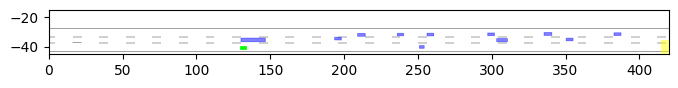

In [43]:
scenario_path = "scenarios/highd_scenarios/ZAM_HighD-13_7_T-1"

#======================================================#
with open("scenarios/highd_config.yaml") as file:
    global_config = yaml.load(file, Loader=yaml.FullLoader)
with open(scenario_path + ".yaml") as file:
    scenario_config = yaml.load(file, Loader=yaml.FullLoader)
config = merge_config(global_config, scenario_config)

scenario, _ = CommonRoadFileReader(scenario_path + ".xml").open()

fig = plt.figure(figsize=(12, 2))
anim = animation.FuncAnimation(fig, 
                               plot_raw_scenario, 
                               fargs=[scenario, config], 
                               frames=range(config["simulation_duration"]), 
                               interval=200, 
                               blit=False)
HTML(anim.to_html5_video())


## Run a single scenario

In [7]:
scenario_path = "scenarios/highd_scenarios/ZAM_HighD-13_7_T-1"
results_folder = "results/"


with open("scenarios/highd_config.yaml") as file:
    global_config = yaml.load(file, Loader=yaml.FullLoader)
with open(scenario_path + ".yaml") as file:
    scenario_config = yaml.load(file, Loader=yaml.FullLoader)
config = merge_config(global_config, scenario_config)

scenario1, _ = CommonRoadFileReader(scenario_path + ".xml").open()
scenario2, _ = CommonRoadFileReader(scenario_path + ".xml").open()

config['occlusion_params']['save_shadows'] = True

config['occlusion_params']['ideal_tracking_enabled'] = False
config['occlusion_params']['velocity_tracking_enabled'] = False
untracked_results = step_simulation(scenario2, config)

config['occlusion_params']['velocity_tracking_enabled'] = True
tracked_results = step_simulation(scenario1, config)

config['occlusion_params']['ideal_tracking_enabled'] = True
ideal_results = step_simulation(scenario1, config)

save_path = os.path.join(results_folder, str(scenario1.scenario_id))
save_results(save_path, tracked_results, untracked_results, ideal_results, scenario1, scenario_config)

TypeError: save_results() missing 1 required positional argument: 'scenario_config'

## Visualise single result

In [9]:
results_file = "results/ZAM_HighD-13_7_T-1"

data = load_results(results_file)

#### Animation of novel method

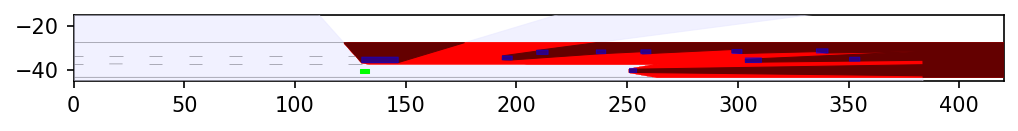

In [10]:
ego_vehicle = data["novel_method"]["ego_vehicle"]
scenarios = data["novel_method"]["scenarios"]
views = data["novel_method"]["views"]
simulation_length = data["simulation_length"]

fig = plt.figure(figsize=(12, 2), dpi=150)
anim = animation.FuncAnimation(fig,
                               plot_result_scenario, 
                               fargs=[ego_vehicle, scenarios, views], 
                               frames=simulation_length, 
                               interval=200, 
                               blit=False)
HTML(anim.to_html5_video())

#### Animation of baseline method

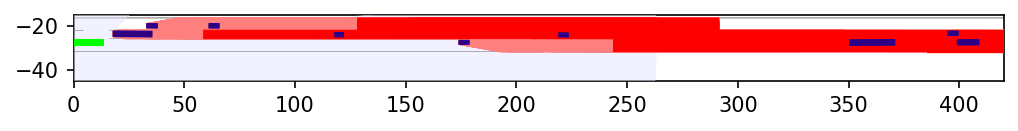

In [36]:
ego_vehicle = data["ideal_method"]["ego_vehicle"]
scenarios = data["ideal_method"]["scenarios"]
views = data["baseline_method"]["views"]
simulation_length = data["simulation_length"]

fig = plt.figure(figsize=(12, 2), dpi=150)
anim = animation.FuncAnimation(fig, 
                               plot_result_scenario, 
                               fargs=[ego_vehicle, scenarios, views], 
                               frames=simulation_length, 
                               interval=200, 
                               blit=False)
HTML(anim.to_html5_video())

#### Propagation of shadow volumes

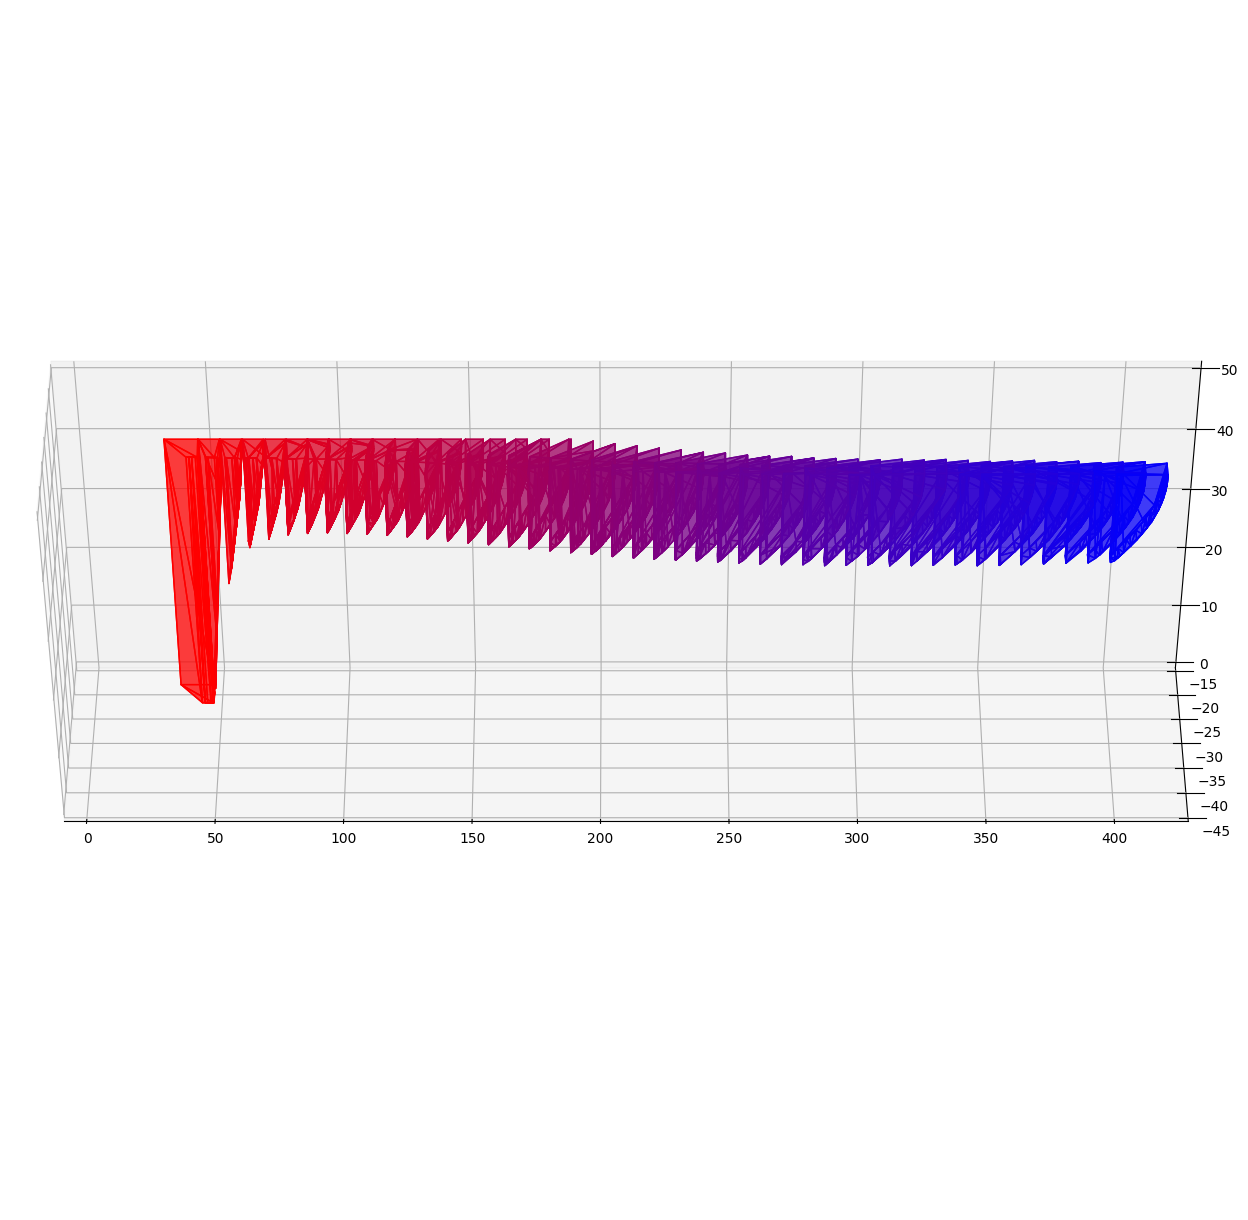

Update time novel method:  0.19916320645652172
Prediction time novel method:  0.6494476660434784
Update time baseline method:  0.07327589476086956
Prediction time baseline method:  1.0050035498478262


In [9]:
simulation_length = data["simulation_length"]
shadows_novel = data["novel_method"]["shadows"]
shadows_to_plot = [1]
if len(shadows_to_plot) == 0:
    shadows_to_plot = np.arange(len(shadows_novel))
for shadow in shadows_to_plot:
    Visualizer().plot_3D_shadows(shadows_novel[shadow],simulation_length,np.arange(0, simulation_length))

#### RSS distance comparisson

Text(0, 0.5, 'Distance Headway [m]')

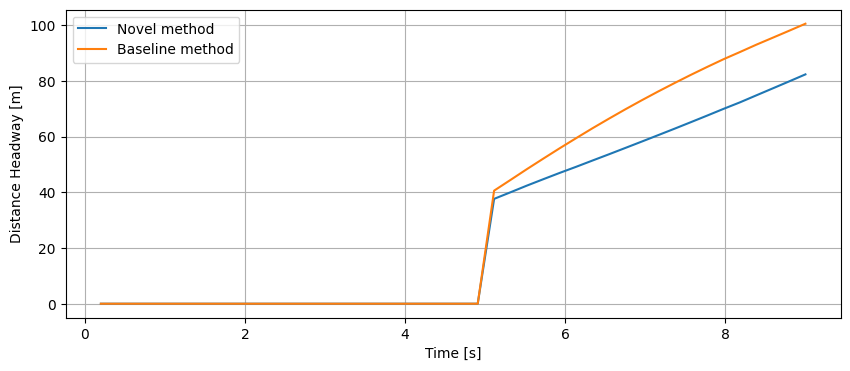

In [86]:
from python_scripts.utilities import find_RSS_distance

ego_novel = data["novel_method"]["ego_vehicle"]
ego_baseline = data["baseline_method"]["ego_vehicle"]
scenario = data["scenario"]
simulation_length = data["simulation_length"]

# Might need to rewrite RSS_distance function a bit
dists_novel = find_RSS_distance(ego_novel, scenario, config)
dists_baseline = find_RSS_distance(ego_baseline, scenario, config)
time = np.linspace(0.2, simulation_length/5, simulation_length-1) #assuming dt = 0.2

plt.figure(figsize=(10,4))
labels = ['Novel method','Baseline method']

plt.plot(time, dists_novel, label=labels[0])
plt.plot(time, dists_baseline, label=labels[1])
plt.legend()
plt.grid()

plt.xlabel('Time [s]')
plt.ylabel('Distance Headway [m]')

#### Velocity comparisson

(0.0, 9.0)

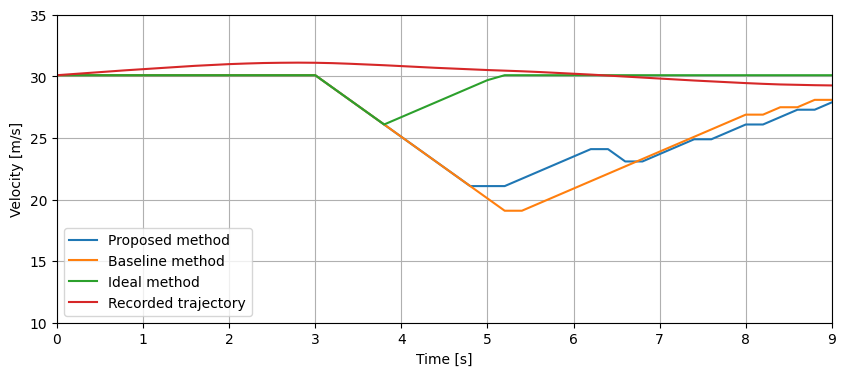

In [40]:
ego_novel = data["novel_method"]["ego_vehicle"]
ego_baseline = data["baseline_method"]["ego_vehicle"]
ego_ideal = data["ideal_method"]["ego_vehicle"]
ego_recorded = data["recorded_ego_speed"]

plt.figure(figsize=(10, 4))
labels = ['Proposed method','Baseline method', 'Ideal method', 'Recorded trajectory']
for idx, vehicle in enumerate([ego_novel, ego_baseline, ego_ideal]):
    velocities = [round(vehicle.initial_state.velocity, 2)]
    time = [round(vehicle.initial_state.time_step/10, 2)]
    for state in vehicle.prediction.trajectory.state_list:
        velocities.append(round(state.velocity, 2))
        time.append(round(state.time_step/5, 2))
    plt.plot(time, velocities, label=labels[idx])
plt.plot(time, ego_recorded[::5], label=labels[-1]) #forgot to downsample recorded vel
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid()
plt.ylim(10, 35)
plt.xlim(0,9)

#### Computational times

In [11]:
print("Update time novel method: ", data["novel_method"]["computational_time"]["update_step"])
print("Prediction time novel method: ", data["novel_method"]["computational_time"]["prediction_step"])
print("Update time baseline method: ", data["baseline_method"]["computational_time"]["update_step"])
print("Prediction time baseline method: ", data["baseline_method"]["computational_time"]["prediction_step"])

Update time novel method:  0.0750616485869565
Prediction time novel method:  2.0609161908913047
Update time baseline method:  []
Prediction time baseline method:  []


## Run all scenarios

In [7]:
skip_existing = True            # Skips any scenarios that already have existing results.
scenario_path = "scenarios/highd_scenarios"
results_path = "results/highd_simulations_pickle"

In [ ]:
path_xml = os.path.join(scenario_path, "*.xml")
path_yaml = os.path.join(scenario_path, "*.yaml")

xml_list = sorted(glob.glob(path_xml))
yaml_list = sorted(glob.glob(path_yaml))

with open("scenarios/highd_config.yaml") as file:
    global_config = yaml.load(file, Loader=yaml.FullLoader)

for xml_file, yaml_file in tqdm.tqdm(zip(xml_list, yaml_list), total=len(xml_list), desc="Iterating over simulations"):
    scenario1, _ = CommonRoadFileReader(xml_file).open()
    scenario2, _ = CommonRoadFileReader(xml_file).open()
    with open(yaml_file) as file:
        scenario_config = yaml.load(file, Loader=yaml.FullLoader)
    config = merge_config(global_config, scenario_config)

    if skip_existing and os.path.isfile(os.path.join(results_path, str(scenario1.scenario_id))):
        continue

    try:
        config['occlusion_params']['velocity_tracking_enabled'] = True
        tracked_results = step_simulation(scenario1, config)

        config['occlusion_params']['velocity_tracking_enabled'] = False
        untracked_results = step_simulation(scenario2, config)

        save_path = os.path.join(results_path, str(scenario1.scenario_id))
        save_results(save_path, tracked_results, untracked_results, scenario1, scenario_config)
    
    except Exception as e:
        print("Simulation raised an error for scenario ", scenario1.scenario_id)

## Visualise all results

In [3]:
single_results_folder = "results/highd_simulations_pickle"
batch_results_path = "results/batch_results"

single_to_batch_results(single_results_folder, batch_results_path)

 97%|█████████▋| 380/393 [03:57<00:07,  1.70it/s]

Could not load results for  ZAM_HighD-39_5_T-1


100%|██████████| 393/393 [04:06<00:00,  1.59it/s]


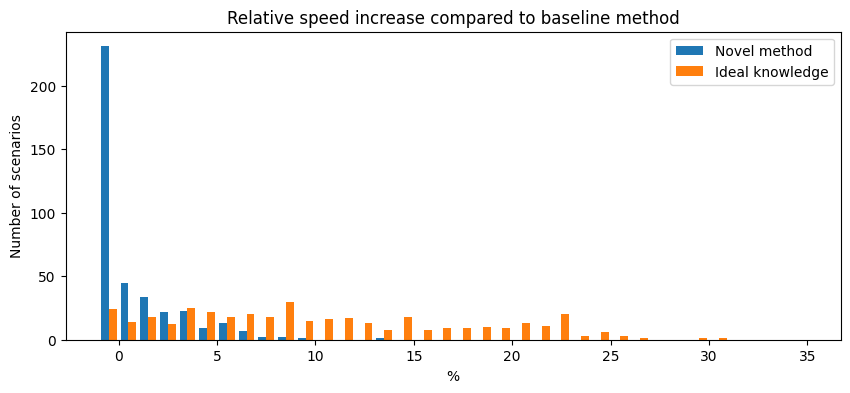

In [40]:
batch_results = pd.read_pickle(batch_results_path)

fig = plt.figure(figsize=(10,4))
plt.hist([(batch_results["avg_vel_novel"]/batch_results["avg_vel_baseline"]-1)*100,
          (batch_results["avg_vel_ideal"]/batch_results["avg_vel_baseline"]-1)*100], 
          [-1, 0.0001, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
          label = ["novel method", "recorded_velocity"])
plt.title("Relative speed increase compared to baseline method")
plt.xlabel("%")
plt.ylabel("Number of scenarios")
plt.legend(["Novel method", "Ideal knowledge"])
plt.show()


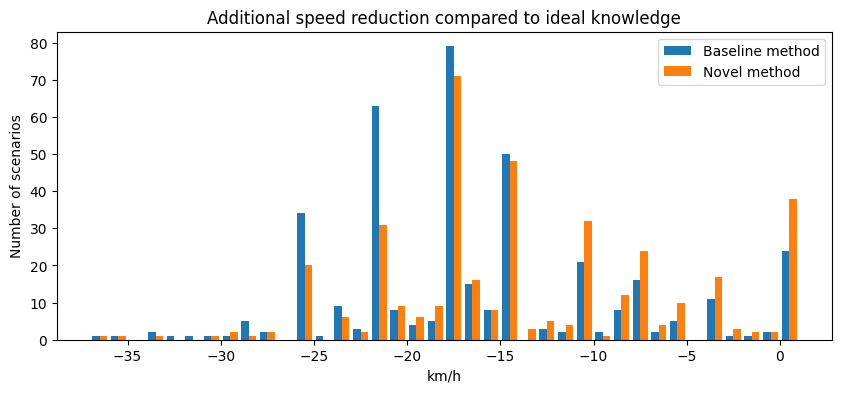

In [25]:
fig = plt.figure(figsize=(10,4))
plt.hist([(batch_results["min_vel_baseline"] - batch_results["min_vel_ideal"])*3.6,
          (batch_results["min_vel_novel"] - batch_results["min_vel_ideal"])*3.6], 
         np.arange(-37.0001, 1.9999),
         label = ["novel method", "baseline method"])
plt.title("Additional speed reduction compared to ideal knowledge")
plt.xlabel("km/h")
plt.ylabel("Number of scenarios")
plt.legend(["Baseline method", "Novel method"])
plt.show()

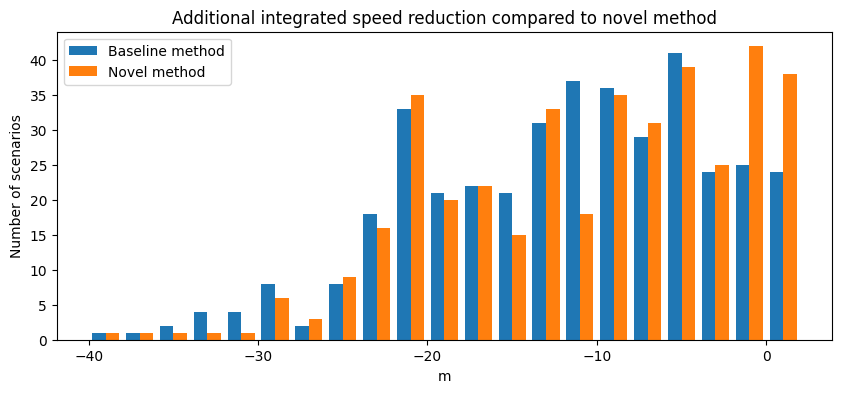

In [30]:
fig = plt.figure(figsize=(10,4))
plt.hist([batch_results["integrated_vel_reduction_baseline"] - batch_results["integrated_vel_reduction_ideal"],
          batch_results["integrated_vel_reduction_novel"] - batch_results["integrated_vel_reduction_ideal"]], 
         np.arange(-40.0001, 3.9999,2),
         label = ["novel method", "baseline method"])
plt.title("Additional integrated speed reduction compared to novel method")
plt.xlabel("m")
plt.ylabel("Number of scenarios")
plt.legend(["Baseline method", "Novel method"])
plt.show()

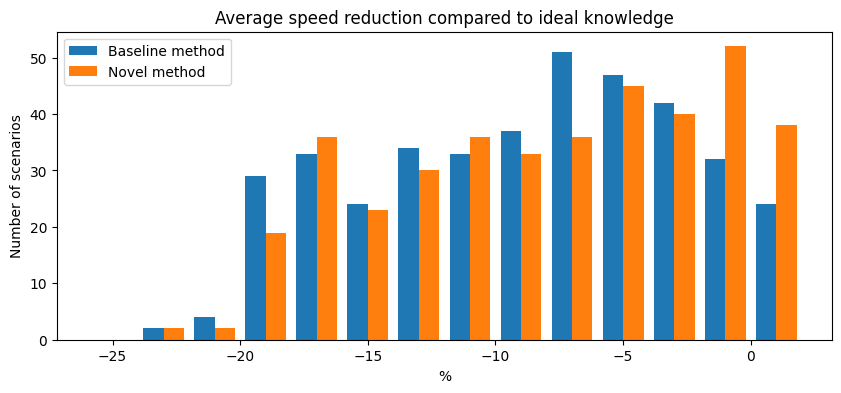

In [39]:
fig = plt.figure(figsize=(10,4))
plt.hist([(batch_results["avg_vel_baseline"]/batch_results["avg_vel_ideal"]-1)*100,
          (batch_results["avg_vel_novel"]/batch_results["avg_vel_ideal"]-1)*100], 
          np.arange(-26.0001, 2.9999,2),
          label = ["Baseline method", "Novel method"])
plt.title("Average speed reduction compared to ideal knowledge")
plt.xlabel("%")
plt.ylabel("Number of scenarios")
plt.legend(["Baseline method", "Novel method"])
plt.show()

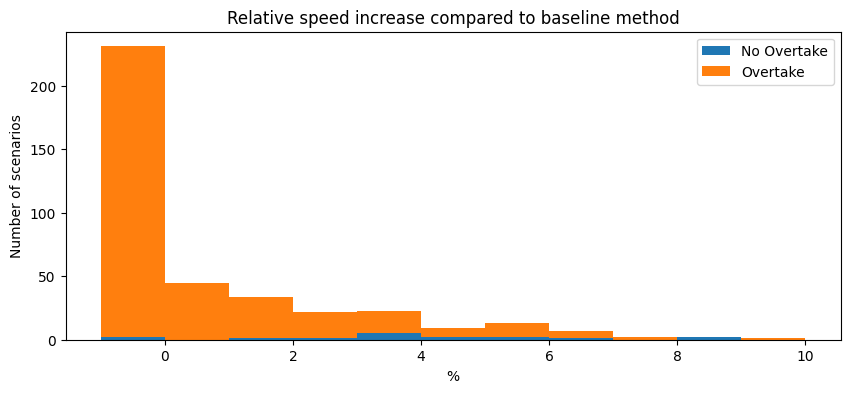

In [6]:
fig = plt.figure(figsize=(10,4))
plt.hist([(batch_results[batch_results.is_overtake == True]["avg_vel_novel"]/batch_results[batch_results.is_overtake == True]["avg_vel_baseline"]-1)*100,
          (batch_results[batch_results.is_overtake == False]["avg_vel_novel"]/batch_results[batch_results.is_overtake == False]["avg_vel_baseline"]-1)*100], 
          [-1, 0.0001, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          stacked=True)
plt.title("Relative speed increase compared to baseline method")
plt.xlabel("%")
plt.ylabel("Number of scenarios")
plt.legend(["No Overtake", "Overtake"])
plt.show()

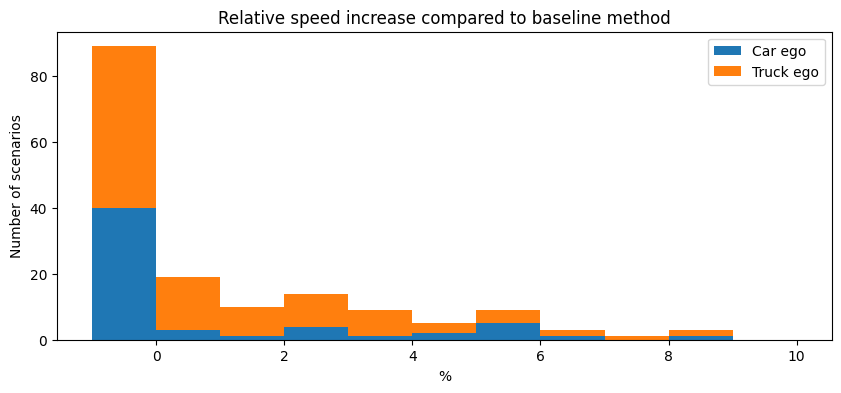

In [11]:
fig = plt.figure(figsize=(10,4))
plt.hist([(batch_results[batch_results.vehicle_type == "Car"]["avg_vel_novel"]/batch_results[batch_results.vehicle_type == "Car"]["avg_vel_baseline"]-1)*100,
          (batch_results[batch_results.vehicle_type == "Truck"]["avg_vel_novel"]/batch_results[batch_results.vehicle_type == "Truck"]["avg_vel_baseline"]-1)*100], 
          [-1, 0.0001, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          stacked=True)
plt.title("Relative speed increase compared to baseline method")
plt.xlabel("%")
plt.ylabel("Number of scenarios")
plt.legend(["Car ego", "Truck ego"])
plt.show()

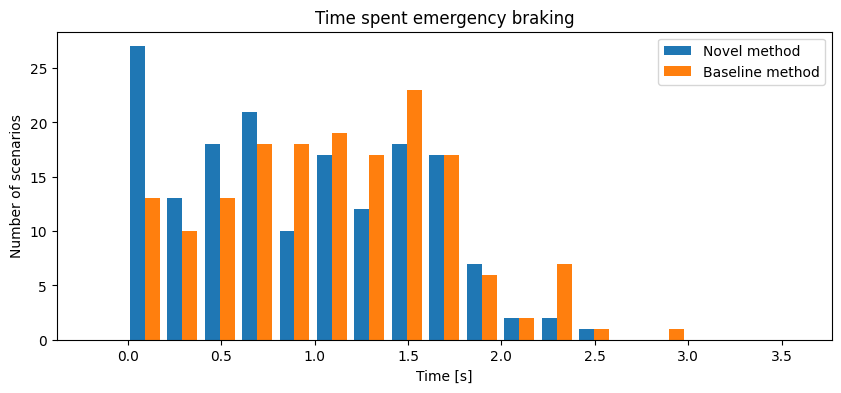

In [12]:
fig = plt.figure(figsize=(10,4))
plt.hist([batch_results["n_brakes_novel"]*0.2,
          batch_results["n_brakes_baseline"]*0.2], 
          np.linspace(-0.21, 3.6, 20))
plt.title("Time spent emergency braking")
plt.xlabel("Time [s]")
plt.ylabel("Number of scenarios")
plt.legend(["Novel method", "Baseline method"])
plt.show()

In [64]:
sorted_df = batch_results.sort_values("n_brakes_novel", ascending=False)

for i in range(10):
    print(sorted_df["scenario_id"].values[i])

ZAM_HighD-13_3_T-1
ZAM_HighD-48_11_T-1
ZAM_HighD-47_4_T-1
ZAM_HighD-37_5_T-1
ZAM_HighD-55_1_T-1
ZAM_HighD-48_4_T-1
ZAM_HighD-11_4_T-1
ZAM_HighD-31_9_T-1
ZAM_HighD-13_4_T-1
ZAM_HighD-39_4_T-1


In [116]:
batch_results["recorded_ratio"] = batch_results["avg_vel_recorded"]/batch_results["avg_vel_baseline"]
sorted_df = batch_results.sort_values("recorded_ratio", ascending=False)

for i in range(10):
    print(sorted_df["scenario_id"].values[i], sorted_df["recorded_ratio"].values[i]*100-100)
    print(sorted_df["avg_vel_recorded"].values[i], sorted_df["avg_vel_baseline"].values[i], sorted_df["ego_speed"].values[i])

ZAM_HighD-13_3_T-1 38.491037644486084
31.190000000000005 22.521312953164813 31.19
ZAM_HighD-48_11_T-1 35.68514217563239
30.88 22.758571428571432 30.88
ZAM_HighD-55_1_T-1 34.38577390673197
31.740000000000002 23.618571428571435 31.74
ZAM_HighD-35_2_T-1 32.84078601268757
24.53 18.46571428571429 24.53
ZAM_HighD-36_11_T-1 32.50863060989647
29.610000000000007 22.345714285714287 29.61
ZAM_HighD-6_12_T-1 31.751692977493263
22.985023923444974 17.445714285714292 23.01
ZAM_HighD-53_4_T-1 31.39213775178689
23.110000000000007 17.58857142857143 23.11
ZAM_HighD-6_7_T-1 30.843363093770023
30.46033492822967 23.280000000000005 30.48
ZAM_HighD-6_6_T-1 30.832666266426543
23.59473684210527 18.03428571428572 23.62
ZAM_HighD-18_1_T-1 30.40187088436204
30.269999999999992 23.21285714285715 30.27
